In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [1]:
import os #파일경로 불러오기용
import cv2 #이미지 처리용
import pandas as pd #데이터 프레임 조작용

In [3]:
from PIL import Image
def create_df(data_path):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """
    df = pd.DataFrame({})
    data_dir_list = os.listdir(data_path)
    print(data_dir_list)
    for i in range(len(data_dir_list)):
      file_list = os.listdir(data_path + "/" + data_dir_list[i])
      img_path_list = []
      for j in range(len(file_list)):
        img_path = data_path + "/" + data_dir_list[i] + "/" +file_list[j]
        try:
          image = Image.open(img_path)
          image.verify()
          img_path_list.append(img_path)
        except:
          print(img_path)
          pass
      df = pd.concat([df,pd.DataFrame({'File_path':img_path_list,'Label':data_dir_list[i]})])
      print(data_dir_list[i],len(file_list))

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    return df

In [4]:
df = create_df('F:/PDC_2022/PDC_2022/track1/submission/dataset/train')

['cse', 'hh', 'rg', 'wb', 'wjj']
cse 1159
hh 752
rg 1036
wb 1028
wjj 1053


In [5]:
display(df)

File_path Label
0     F:/PDC_2022/PDC_2022/track1/submission/dataset...    rg
1     F:/PDC_2022/PDC_2022/track1/submission/dataset...   wjj
2     F:/PDC_2022/PDC_2022/track1/submission/dataset...   wjj
3     F:/PDC_2022/PDC_2022/track1/submission/dataset...    hh
4     F:/PDC_2022/PDC_2022/track1/submission/dataset...    rg
...                                                 ...   ...
5023  F:/PDC_2022/PDC_2022/track1/submission/dataset...   wjj
5024  F:/PDC_2022/PDC_2022/track1/submission/dataset...    wb
5025  F:/PDC_2022/PDC_2022/track1/submission/dataset...    hh
5026  F:/PDC_2022/PDC_2022/track1/submission/dataset...    rg
5027  F:/PDC_2022/PDC_2022/track1/submission/dataset...    rg

[5028 rows x 2 columns]

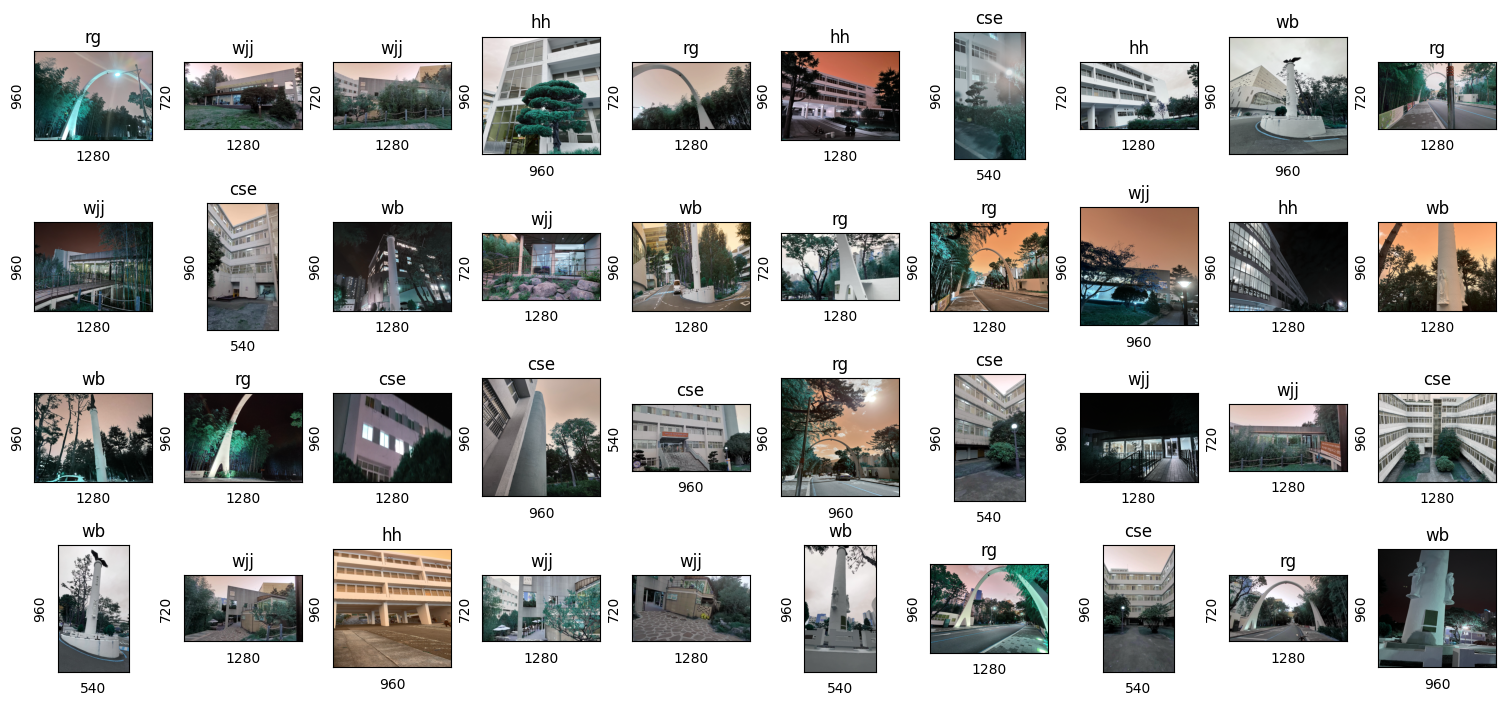

In [6]:
import matplotlib.pyplot as plt
"""
  데이터 확인(이미지 라벨, 가로크기,세로크기)
"""
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = cv2.imread(df.File_path[i])
    ax.imshow(img)
    ax.set_title(df.Label[i], fontsize = 12)
    ax.set_xlabel(img.shape[1], fontsize=10)
    ax.set_ylabel(img.shape[0], fontsize=10)
plt.tight_layout(pad=0.5)
plt.show()

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
"""
  훈련데이터,검증데이터로 나누기, 9:1, 계층샘플링적용
"""
train_df,val_df = train_test_split(df, test_size=0.1,random_state=0,stratify=df.Label)
print(train_df.shape,val_df.shape)

test_df = create_df('F:/PDC_2022/PDC_2022/track1/submission/dataset/test')

(4525, 2) (503, 2)
['cse', 'hh', 'rg', 'wb', 'wjj']
cse 126
hh 88
rg 113
wb 113
wjj 124


In [9]:
import numpy as np
import tensorflow as tf
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

    val_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_path',
        y_col='Label',
        target_size=(150, 150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=True
    )

    val_images = val_generator.flow_from_dataframe(
        dataframe=val_df,
        x_col='File_path',
        y_col='Label',
        target_size=(150, 150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=True
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_path',
        y_col='Label',
        target_size=(150, 150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )
    
    return train_generator,val_generator,test_generator,train_images,val_images,test_images


In [10]:
train_generator,val_generator,test_generator,train_images,val_images,test_images=create_gen()

Found 4525 validated image filenames belonging to 5 classes.
Found 503 validated image filenames belonging to 5 classes.
Found 564 validated image filenames belonging to 5 classes.


In [11]:
len(train_images)

71

In [12]:
#4층 CNN모델
#GPU훈련
with tf.device('/device:GPU:0'):
  # 시퀀셜모델(레이어모델) 생성
  cnn = tf.keras.models.Sequential()

  # 1층 convolution&pooling
  cnn.add(tf.keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation='relu', input_shape=(150,150,3)))
  cnn.add(tf.keras.layers.MaxPool2D(padding='SAME'))

  cnn.add(tf.keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation='relu'))
  cnn.add(tf.keras.layers.MaxPool2D(padding='SAME'))

  cnn.add(tf.keras.layers.Conv2D(128, kernel_size=3, padding="SAME", activation='relu'))
  cnn.add(tf.keras.layers.MaxPool2D(padding='SAME'))

  cnn.add(tf.keras.layers.Conv2D(128, kernel_size=3, padding="SAME", activation='relu'))
  cnn.add(tf.keras.layers.MaxPool2D(padding='SAME'))

    # classification layer (분류 - Dense)
  cnn.add(tf.keras.layers.Flatten())
  cnn.add(tf.keras.layers.Dropout(0.5))
  cnn.add(tf.keras.layers.Dense(512, activation='relu'))

  # 5층 Softmax분류결과출력 신경망
  cnn.add(tf.keras.layers.Dense(units=5, activation='softmax'))

  # compile,adam,categorical_crossentropy
  cnn.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
  cnn.summary()

  #에포크 10 훈련
  history = cnn.fit(x = train_images,validation_data=val_images,validation_steps=5,epochs=10,verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 19, 19, 128)      0

In [18]:
#모델 저장
cnn.save('baseline_video_densemodeling_4cnn_val_acc_0.85.h5')

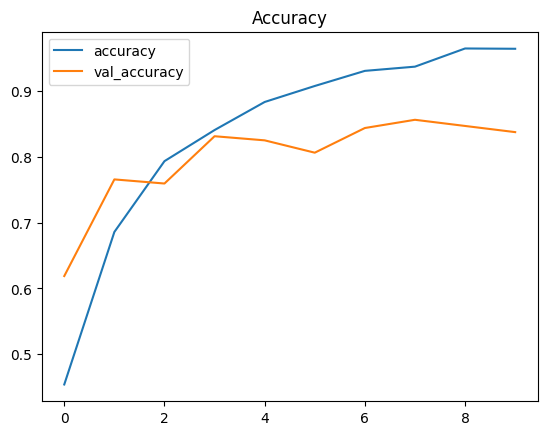

In [13]:
#정확도그래프
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

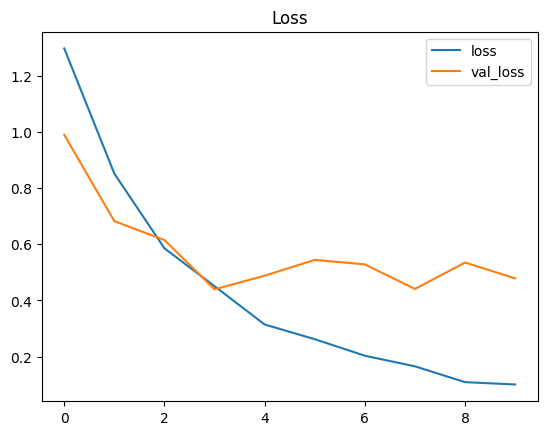

In [14]:
#오차그래프
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [15]:
test_images.class_indices

{'cse': 0, 'hh': 1, 'rg': 2, 'wb': 3, 'wjj': 4}

'예측률 : 100.00%'

'클래스 = wb'

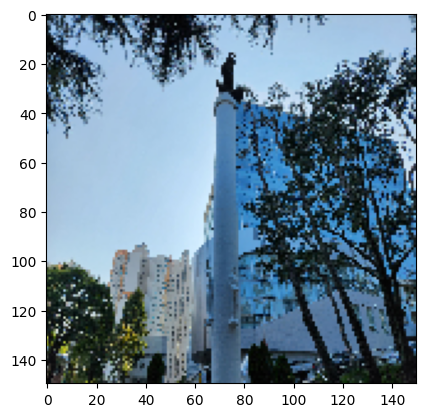

In [16]:
#모델 로드 후 개별 이미지 예측 테스트
import pandas as pd
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt
def printmd(string):
    display(string)
class_dictionary = test_images.class_indices
model = load_model('F:/PDC_2022/PDC_2022/track1/submission/baseline_video_densemodeling_4cnn_val_acc_0.85.h5')
IMAGE_SIZE    = (150, 150)
number_1 = int(input("번호 입력 : ")) # 10, 50, 100
test_image = image.load_img(test_df.iloc[number_1, 0]
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"클래스 = {x}")
    break

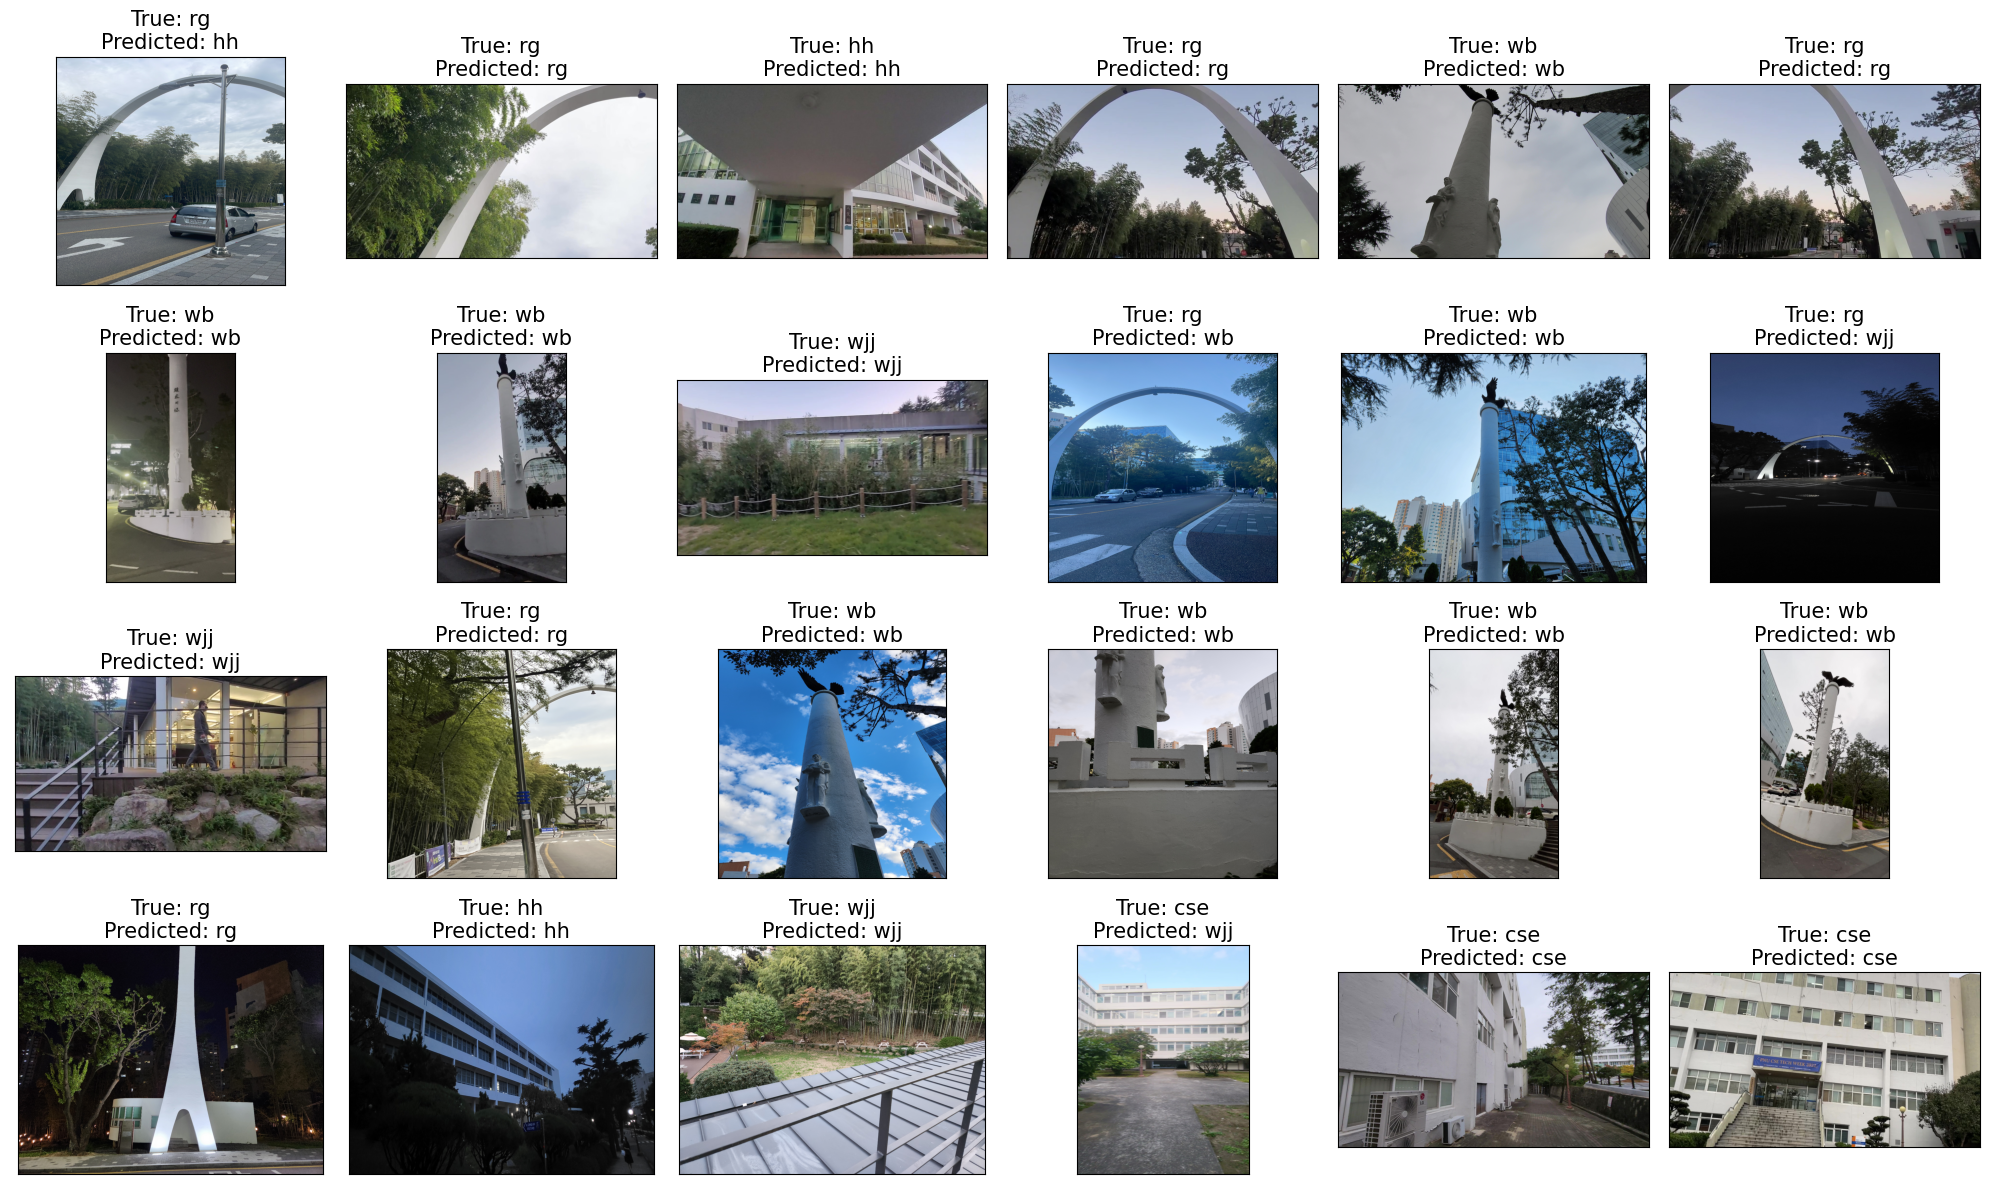

In [17]:
#여러 이미지 테스트
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.File_path.iloc[i]))
    test_image = image.load_img(test_df.iloc[i, 0]
                            ,target_size =IMAGE_SIZE )
    test_image = image.img_to_array(test_image)
    test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
    prediction = model.predict(test_image)
    df = pd.DataFrame({'pred':prediction[0]})
    df = df.sort_values(by='pred', ascending=False, na_position='first')
    for x in class_dictionary:
      if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
        ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {x}", fontsize = 15)
plt.tight_layout()
plt.show()

In [18]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
model = tf.keras.models.load_model('F:/PDC_2022/PDC_2022/track1/submission/baseline_video_densemodeling_4cnn_val_acc_0.85.h5')
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_path',
        y_col='Label',
        target_size=(150, 150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=1,
        shuffle=False)

result = dict()
for cls in test_images.class_indices.keys():
        result[test_images.class_indices[cls]] = [0, 0]
pbar = tqdm(total=test_images.samples, dynamic_ncols=True)
for batch, sample in enumerate(test_images):
        img, label = sample[0], int(np.argmax(sample[1],1))
        output = model.predict(img)
        pred = int(np.argmax(output,1))
        gt = label

        result[gt][1] += 1
        if pred == gt:
                result[gt][0] += 1
        if batch == int(test_images.samples):
                break
        pbar.update(1)

pbar.close()
correct_all = 0
total_all = 0
classes = dict(map(reversed,test_images.class_indices.items()))
for k, v in result.items():
        cls = classes[k]
        correct = result[k][0]
        total = result[k][1]
        acc = 100. * correct / (total + 1e-8)
        print('{:^8s} | {:^8d} | {:^8d} | {:>10.4f}'.format(
                cls, correct, total, acc
        ))

        correct_all += correct
        total_all += total

acc_all = 100. * correct_all / (total_all + 1e-8)
print('{:^8s} | {:^8d} | {:^8d} | {:>10.4f}'.format("ALL", correct_all, total_all, acc_all))

Found 564 validated image filenames belonging to 5 classes.


100%|██████████| 564/564 [00:29<00:00, 19.09it/s]

  cse    |   117    |   126    |    92.8571
   hh    |    71    |    88    |    80.6818
   rg    |   101    |   114    |    88.5965
   wb    |   109    |   113    |    96.4602
  wjj    |   110    |   124    |    88.7097
  ALL    |   508    |   565    |    89.9115
